# Analizando endereços

Nesse notebook vamos coletar os de alguns endereços diferentes, fazer a prova de conceito do mapa e analizar o preço de cada endereço

In [11]:
pip install real_estate --upgrade

Requirement already up-to-date: real_estate in c:\users\jaopc\anaconda3\lib\site-packages (0.1.0)
Note: you may need to restart the kernel to use updated packages.


In [17]:
# Para conseguir ler os módulos do projeto
from real_estate import Collector
from real_estate import HeatMap, LocationsMap
import pandas as pd

In [22]:
address1 = Collector("C:/Repos/real-estate-scrapper/real_estate/src/drivers/windows/chromedriver.exe","Perdizes, São Paulo")
address2 = Collector( "C:/Repos/real-estate-scrapper/real_estate/src/drivers/windows/chromedriver.exe","Consolação, São Paulo")
address3 = Collector("C:/Repos/real-estate-scrapper/real_estate/src/drivers/windows/chromedriver.exe","Liberdade, São Paulo")
address_list = [address1, address2, address3]
for address in address_list:
    address.collect_data()
    

In [23]:
address_list = [address1.data, address2.data, address3.data]
df = pd.concat(address_list)

In [24]:
df

,banheiros,distância,endereço,img1,lat,link,lon,preço,quartos,site,texto,área,vagas,valor_de_condominio
0,3,0.467188,"05018-001, Perdizes, São Paulo, Estado de São ...",https://img-us-1.trovit.com/img1br/Cn1UE1Lr1D1...,-23.539956,https://rd.clk.thribee.com/id.Cn1UE1Lr1D1t/ori...,-46.684683,6400,2,trovit,Apartamento 2 quartos para alugar no(a) Perdiz...,117,NaN,NaN
1,1,0.315080,"05011-001, Perdizes, São Paulo, Estado de São ...",https://img-us-1.trovit.com/img1br/G1GP1H91o15...,-23.535409,https://rd.clk.thribee.com/id.G1GP1H91o1517/or...,-46.682102,3200,3,trovit,Casa 3 quartos para alugar no(a) Perdizes\n050...,100,NaN,NaN
2,4,1.961537,"05004-000, Perdizes, São Paulo, Estado de São ...",https://img-us-1.trovit.com/img1br/b1i1O1T1G1-...,-23.534020,https://rd.clk.thribee.com/id.b1i1O1T1G1-111y/...,-46.661935,10000,0,trovit,Comercial para alugar no(a) Perdizes\n05004-00...,394,NaN,NaN
3,2,2.387542,"01246-000, Perdizes, São Paulo, Estado de São ...",https://img-us-1.trovit.com/img1br/SXM-p1u111G...,-23.555635,https://rd.clk.thribee.com/id.SXM-p1u111G/orig...,-46.667331,10000,2,trovit,Comercial para alugar no(a) Perdizes\n01246-00...,250,NaN,NaN
4,3,1.023175,"05022-001, Perdizes, São Paulo, Estado de São ...",https://img-us-1.trovit.com/img1br/D1uW1U1i5_1...,-23.538162,https://rd.clk.thribee.com/id.D1uW1U1i5_1-/ori...,-46.690688,3200,0,trovit,Comercial para alugar no(a) Perdizes\n05022-00...,180,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1,1.310003,"Rua dos Estudantes, 389 - Liberdade, São Paulo...",https://resizedimgs.vivareal.com/crop/240x240/...,-23.555467,https://www.vivareal.com.br/imovel/2512883087,-46.635817,1000,1,vivareal,"Apartamento com Quarto para Aluguel, 45m²\nRua...",45,0.0,300.0
85,2,0.582776,"Rua dos Tapes, 67 - Liberdade, São Paulo - SP",https://resizedimgs.vivareal.com/crop/240x240/...,-23.561640,https://www.vivareal.com.br/imovel/2524367410,-46.630255,1800,2,vivareal,"Apartamento com 2 Quartos para Aluguel, 58m²\n...",58,1.0,555.0
86,1,0.944015,"Rua Barão de Iguape, 985 - Liberdade, São Paul...",https://resizedimgs.vivareal.com/crop/240x240/...,-23.558181,https://www.vivareal.com.br/imovel/2531572322,-46.631963,1600,2,vivareal,"Apartamento com 2 Quartos para Aluguel, 49m²\n...",49,1.0,222.0
87,1,0.817754,"Rua Vergueiro, 819 - Liberdade, São Paulo - SP",https://resizedimgs.vivareal.com/crop/240x240/...,-23.563822,https://www.vivareal.com.br/imovel/2489695073,-46.639184,1600,2,vivareal,"Apartamento com 2 Quartos para Aluguel, 64m²\n...",64,0.0,480.0


## Limpando os dados

In [25]:
# valor_de_condominio não pode ter str para possibilitar contas
df.valor_de_condominio.fillna(0, inplace=True)
df.fillna("Não especificado", inplace=True)

def int2float(valor):
    if isinstance(valor, float):
            valor = int(valor)
    return valor
df.vagas= df.vagas.apply(int2float)
df.head(3)

,banheiros,distância,endereço,img1,lat,link,lon,preço,quartos,site,texto,área,vagas,valor_de_condominio
0,3,0.467188,"05018-001, Perdizes, São Paulo, Estado de São ...",https://img-us-1.trovit.com/img1br/Cn1UE1Lr1D1...,-23.539956,https://rd.clk.thribee.com/id.Cn1UE1Lr1D1t/ori...,-46.684683,6400,2,trovit,Apartamento 2 quartos para alugar no(a) Perdiz...,117,Não especificado,0.0
1,1,0.315080,"05011-001, Perdizes, São Paulo, Estado de São ...",https://img-us-1.trovit.com/img1br/G1GP1H91o15...,-23.535409,https://rd.clk.thribee.com/id.G1GP1H91o1517/or...,-46.682102,3200,3,trovit,Casa 3 quartos para alugar no(a) Perdizes\n050...,100,Não especificado,0.0
2,4,1.961537,"05004-000, Perdizes, São Paulo, Estado de São ...",https://img-us-1.trovit.com/img1br/b1i1O1T1G1-...,-23.534020,https://rd.clk.thribee.com/id.b1i1O1T1G1-111y/...,-46.661935,10000,0,trovit,Comercial para alugar no(a) Perdizes\n05004-00...,394,Não especificado,0.0


## Criando o mapa

In [26]:
map = LocationsMap(df)
map.print()


In [28]:
heat_map = HeatMap(df)
heat_map.print()

## Estatisticas sobre os imóveis

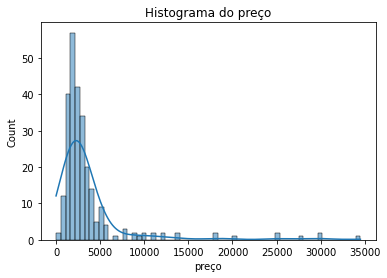

In [65]:
sns.histplot(df.preço, kde=True).set_title("Histograma do preço");

Percebemos que alguns imóveis estavam com o preço muito alto, perto dos 300 mil, investigando esses anúncios vimos que alguns sites possuem edificios por completo para a locação (escritórios). Como o nosso público alvo são estudandes optamos por remover esses outliers 

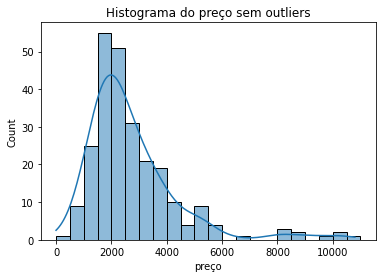

In [66]:
sns.histplot(
    df[df.preço < np.quantile(df.preço, 0.95)].preço, binwidth=500, kde=True
).set_title("Histograma do preço sem outliers");

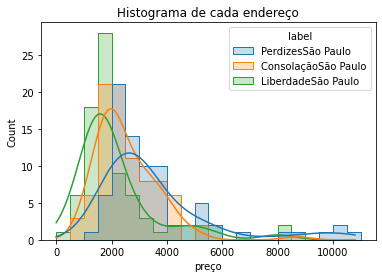

In [73]:
sns.histplot(
    data = df[df.preço < np.quantile(df.preço, 0.95)], x="preço", hue="label", binwidth=500, kde=True, element="step"
).set_title("Preço de cada endereço");

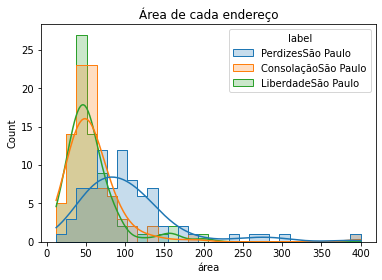

In [75]:
sns.histplot(
    data=df[df.preço < np.quantile(df.preço, 0.95)], x="área", hue="label", kde=True, element="step"
).set_title("Área de cada endereço");